In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
def parse_json_file(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data


def extract_data(json_data, model_name):
    records = []
    for dataset, metrics in json_data.items():
        for metric_name, values in metrics.items():
            if metric_name.startswith("mmlu_"):
                continue
            elif dataset == "glue" and metric_name != "glue":
                continue
            elif (
                dataset == "super-glue-lm-eval-v1"
                and metric_name != "super-glue-lm-eval-v1"
            ):
                continue
            elif dataset == "lambada" and metric_name != "lambada":
                continue
            record = {
                "model": model_name,
                "dataset": metric_name,
            }
            for key, value in values.items():
                if key in [
                    "acc,none",
                    "exact_match,strict-match",
                    "f1,none",
                    "mcc,none",
                    "em,none",
                    "perplexity,none",
                ]:
                    record[key] = value
            records.append(record)
    return records


def extract_model_info(filename):
    parts = filename.split("_")
    model_name = "_".join(parts[1:-2])
    return model_name


def load_data_from_directory(directory):
    all_records = []
    for file_name in os.listdir(directory):
        if file_name.endswith(".json"):
            model_name = extract_model_info(file_name)
            file_path = os.path.join(directory, file_name)
            json_data = parse_json_file(file_path)
            records = extract_data(json_data, model_name)
            all_records.extend(records)
    return pd.DataFrame(all_records)

In [85]:
directory_path = "."

df = load_data_from_directory(directory_path)

In [88]:
df.head(10)

,model,dataset,"acc,none","exact_match,strict-match","f1,none","mcc,none","em,none","perplexity,none"
0,llama_8b_instruct_fp4,arc_challenge,0.520000,NaN,NaN,NaN,NaN,NaN
1,llama_8b_instruct_fp4,hellaswag,0.530000,NaN,NaN,NaN,NaN,NaN
2,llama_8b_instruct_fp4,truthfulqa_mc1,0.290000,NaN,NaN,NaN,NaN,NaN
3,llama_8b_instruct_fp4,winogrande,0.780000,NaN,NaN,NaN,NaN,NaN
4,llama_8b_instruct_fp4,gsm8k,NaN,0.63,NaN,NaN,NaN,NaN
5,llama_8b_instruct_fp4,mmlu,0.639649,NaN,NaN,NaN,NaN,NaN
6,llama_8b_instruct_fp4,glue,0.732815,NaN,0.705174,0.371014,NaN,NaN
7,llama_8b_instruct_fp4,super-glue-lm-eval-v1,0.647866,NaN,0.800053,NaN,0.92,NaN
8,llama_8b_instruct_fp4,lambada,0.000000,NaN,NaN,NaN,NaN,9.325370e+06
9,llama_8b_instruct_fp4,prost,0.620000,NaN,NaN,NaN,NaN,NaN


In [103]:
def plot_dataset(df, dataset_name):
    dataset_df = df[df["dataset"] == dataset_name]

    dataset_melted = dataset_df.melt(
        id_vars=["model"],
        value_vars=[
            "acc,none",
            "exact_match,strict-match",
            "f1,none",
            "mcc,none",
            "em,none",
            "perplexity,none",
        ],
        var_name="metric",
        value_name="value",
    )
    dataset_melted["value"] = dataset_melted["value"].replace(0.0, None)

    dataset_melted = dataset_melted.dropna(subset=["value"])
    dataset_melted["metric"] = dataset_melted["metric"].apply(lambda x: x.split(",")[0])

    sorted_models = sorted(dataset_melted["model"].unique())

    plt.figure(figsize=(12, 6))
    sns.barplot(
        x="model", y="value", hue="metric", data=dataset_melted, order=sorted_models
    )
    plt.title(f"Results for {dataset_name}")
    plt.xlabel("Model")
    plt.ylabel("Metric Value")
    plt.xticks(rotation=45)
    plt.legend(title="Metric")
    plt.show()


dataset_names = df["dataset"].unique()

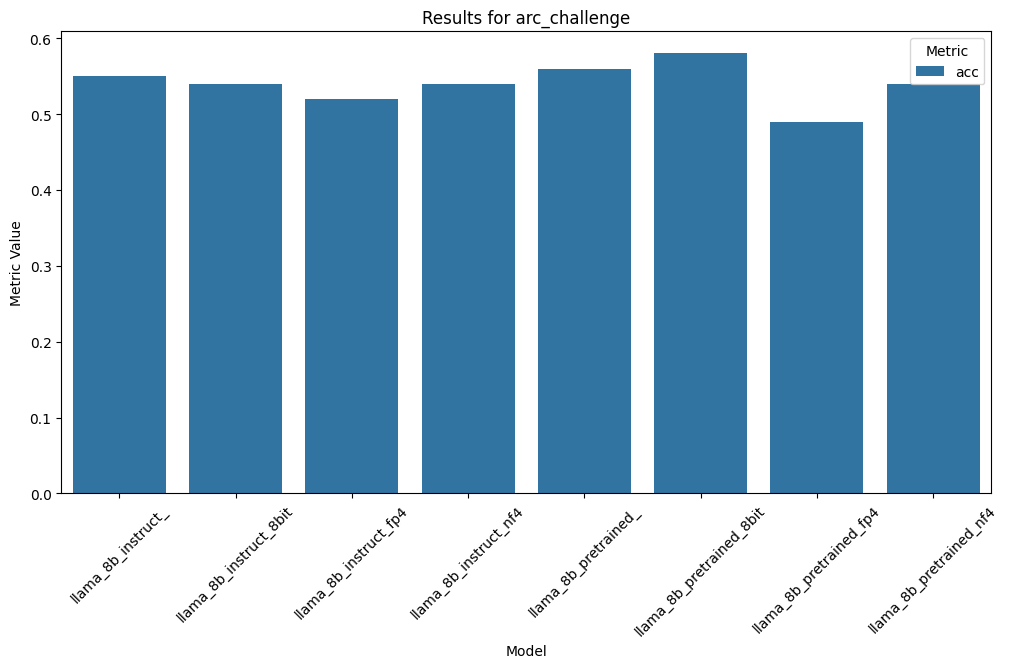

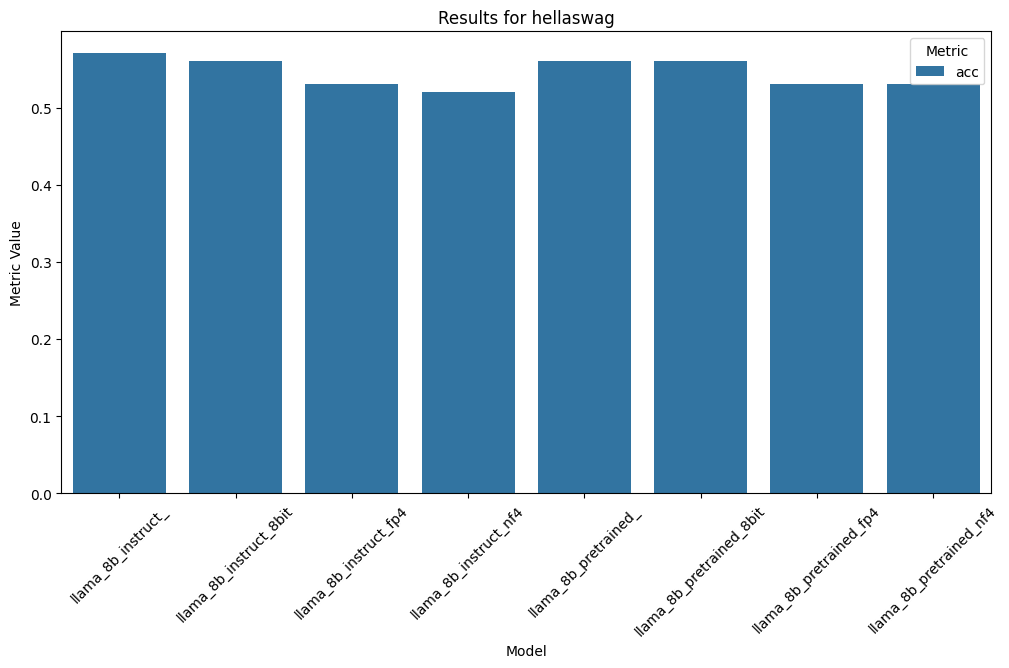

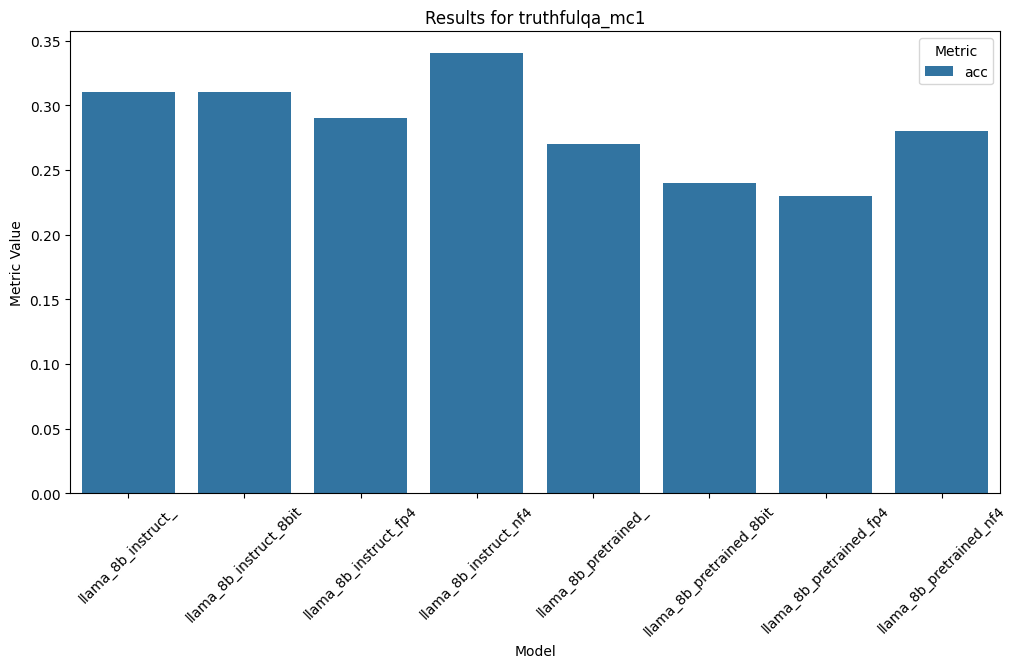

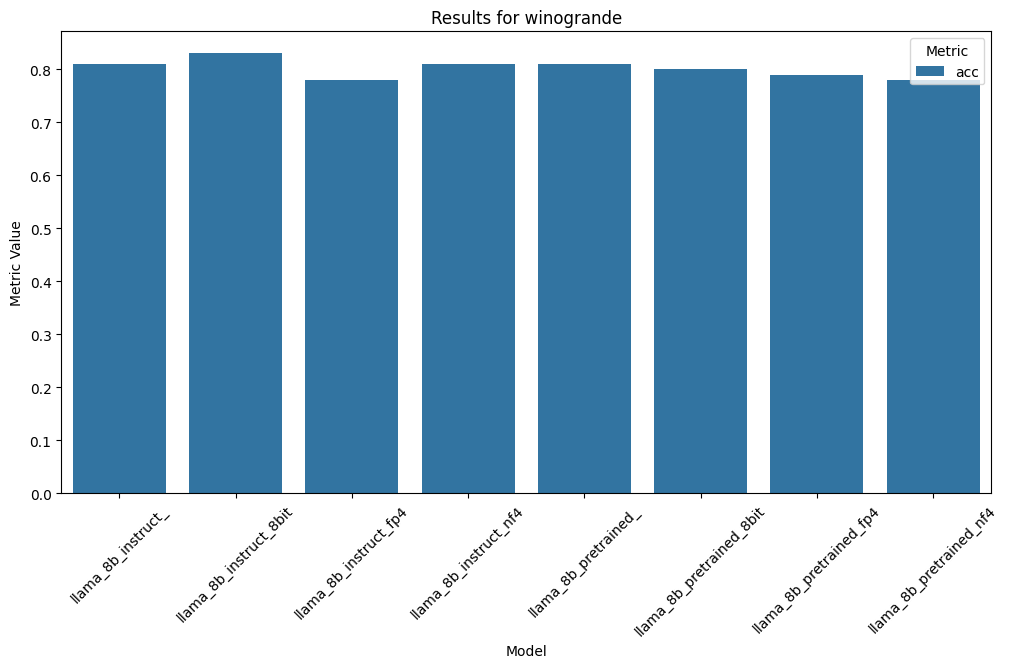

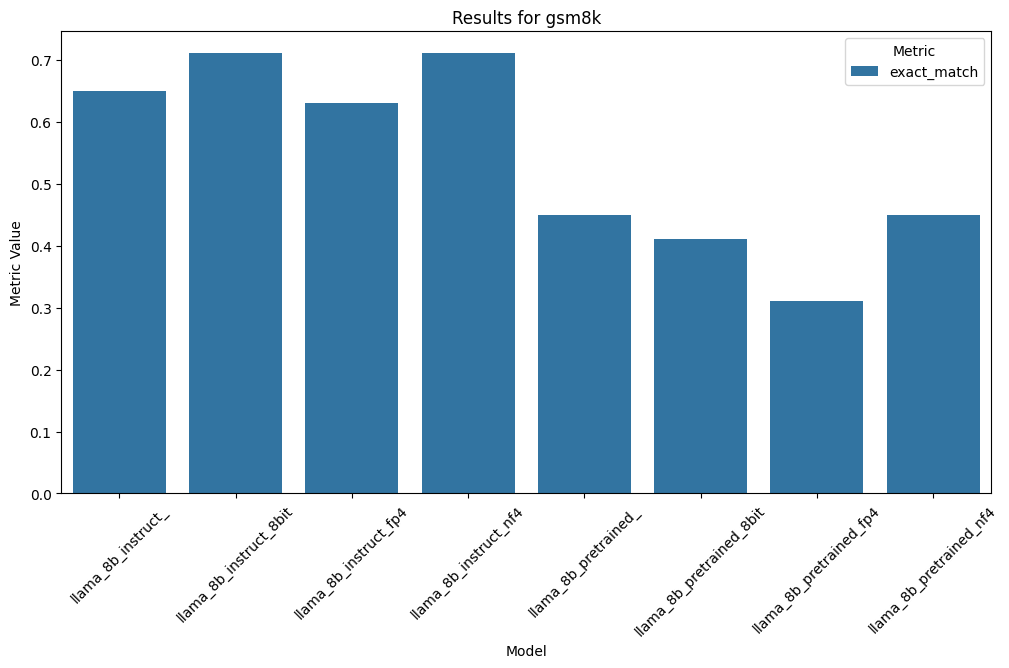

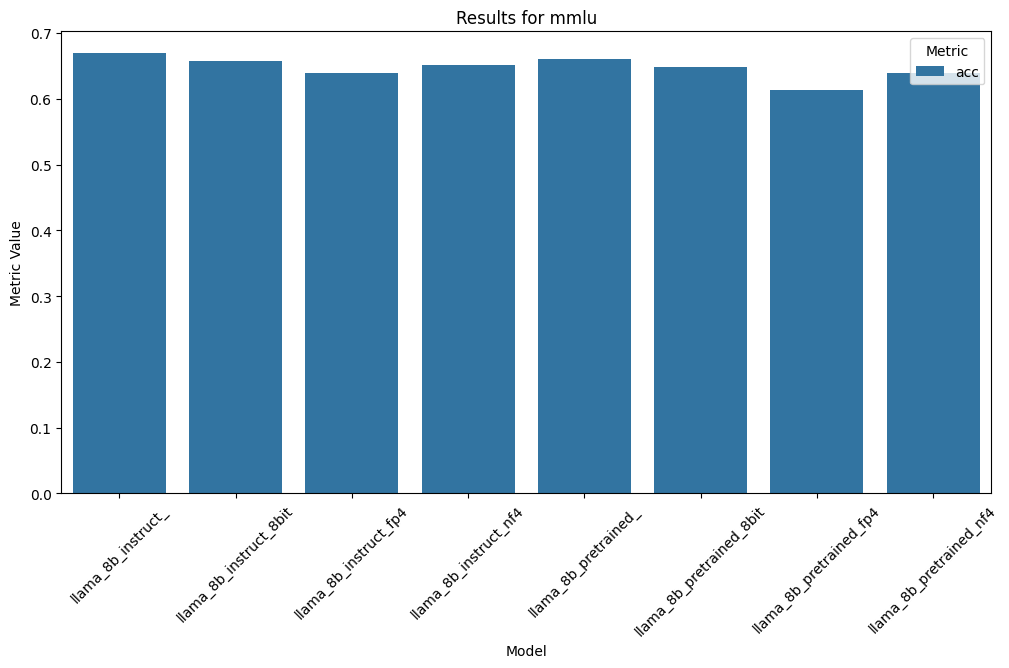

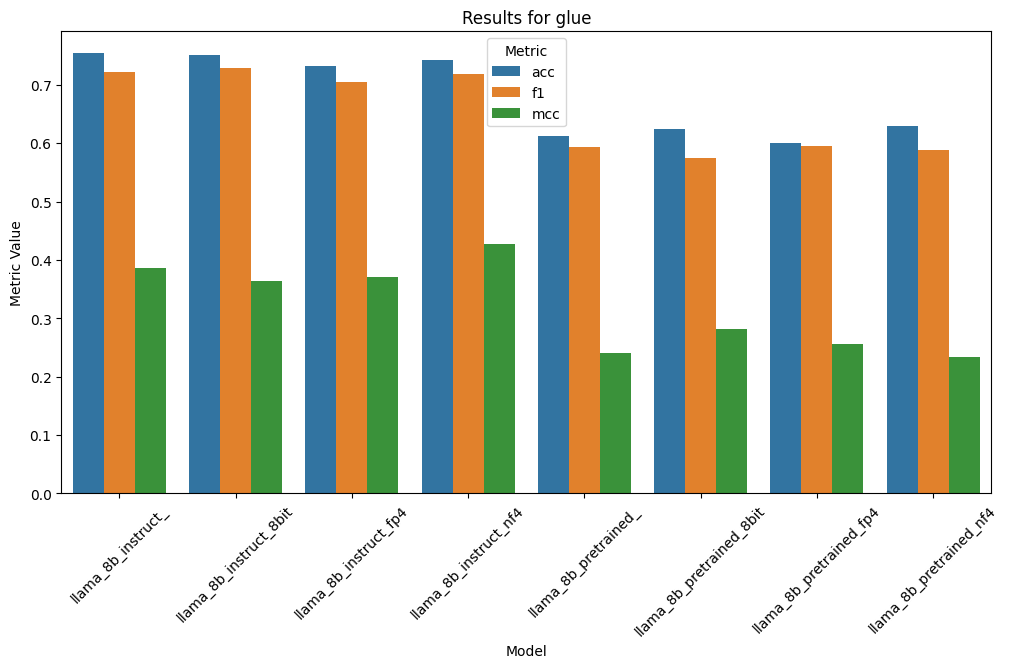

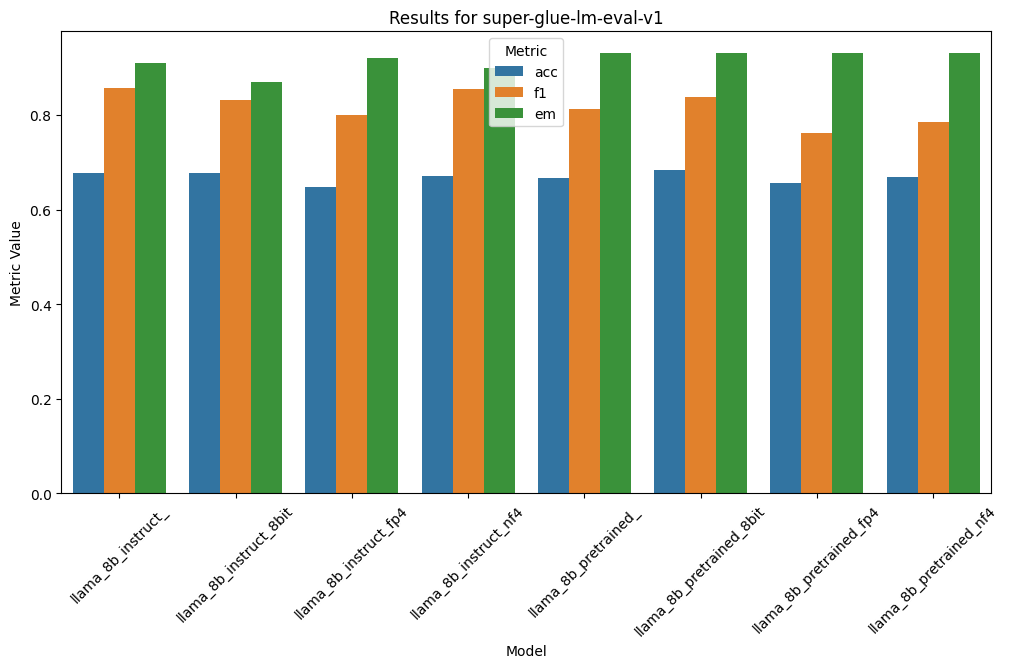

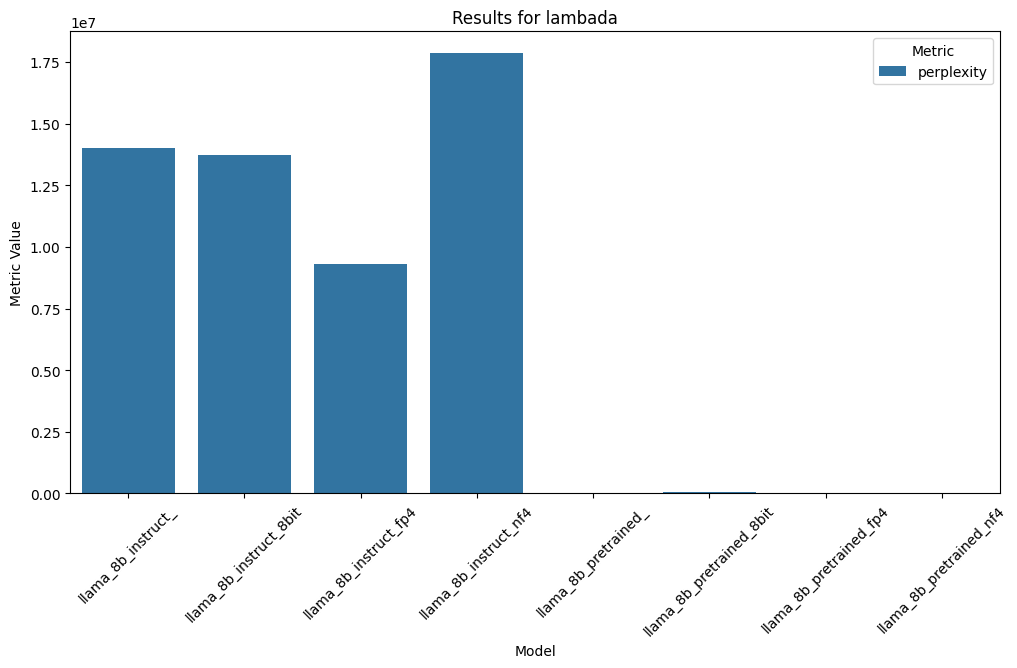

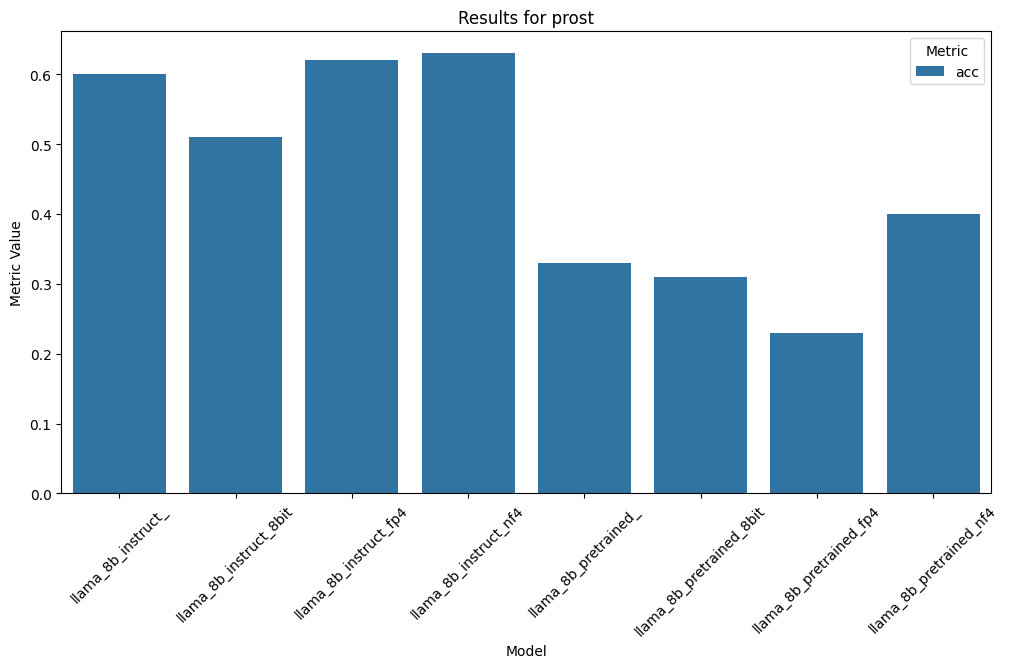

In [104]:
for dataset in dataset_names:
    plot_dataset(df, dataset)